In [29]:
import xarray as xr, numpy as np, pandas as pd             # for working with gridded netcdf data
import regionmask, geopandas as gpd                        # for working with shapefiles
import matplotlib, matplotlib.pyplot as plt, cartopy       # plotting functions

def wrap_lon(ds):
    
    # method to wrap longitude from (0,360) to (-180,180)
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds
    


In [40]:
sf = gpd.read_file("sf_studyregion")

In [30]:
xn,xx,yn,yx = [30,50,-10,10]

kg = wrap_lon(xr.open_dataset("kg_classifications.nc")).kg_cat.sel(lon = slice(xn,xx), lat = slice(yn,yx))

In [31]:
# group individual classes into broader categories
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

# check Koppen-Geiger classifications
pd.read_csv("kg_legend.csv", index_col = "cat")

,code,desc
cat,,
1,Af,"Tropical, rainforest"
2,Am,"Tropical, monsoon"
3,Aw,"Tropical, savannah"
4,BWh,"Arid, desert, hot"
5,BWk,"Arid, desert, cold"
6,BSh,"Arid, steppe, hot"
7,BSk,"Arid, steppe, cold"
8,Csa,"Temperate, dry summer, hot summer"
9,Csb,"Temperate, dry summer, warm summer"


<GeoAxes: title={'center': 'Koppen-Geiger climatology'}, xlabel='lon', ylabel='lat'>

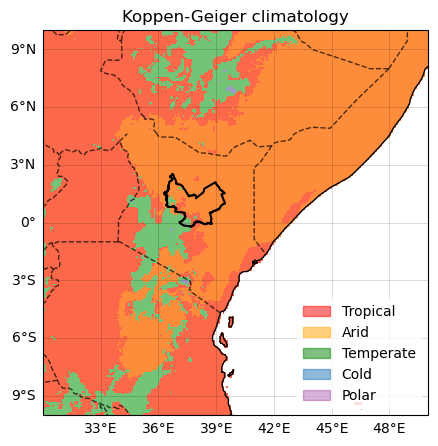

In [42]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add box around area of interest

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
                      matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)], 
           edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")

sf.boundary.plot(ax = plt.gca(), color = "k")